In [1]:
# -- Bib
import os
import sys
sys.path.append("..")

import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from fluxsus.DBFIX import DBFIX
from fluxsus.fluxnets.fluxnets import CityFlux, CityHospitalFlux
from fluxsus.utils_ import f_infomap
from scipy.stats import linregress

PyTables is not installed. No support for HDF output.


In [2]:
# -- Open the three main datasets: CNES, CE GEODATA, SIHSUS.
basepath = os.path.join(os.environ["HOMEPATH"], "Documents", "data")
cnespath = os.path.join(basepath, "opendatasus", "cnes")
sihpath = os.path.join(basepath, "opendatasus", "sihsus", "PARQUET")
geopath = os.path.join(basepath, "shapefilesceqgis")
gml_folder = os.path.join(basepath, "redes_aih")

In [70]:
pop_df = pd.read_excel(os.path.join(geopath, "POP. MUNICIPIO CEARA_ 2009_2023.xlsx"), header=4)[1:-3]
pop_df.columns = ['GEOCOD6','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022', '2022.1']
pop_df["GEOCOD6"] = pop_df["GEOCOD6"].apply(lambda x: x.split(" ")[0])
pop_df["2018-2022(MEAN)"] = pop_df[['2018', '2019','2020','2021','2022']].apply(lambda x: np.mean(x.values), axis=1)
pop_df.head()

,GEOCOD6,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2022.1,2018-2022(MEAN)
1,230010,10483.0,10668.0,10790.0,10908.0,11023.0,11137.0,11259.0,11380.0,11498.0,11619.0,11737.0,11853.0,11965.0,10038.0,10038.0,11442.4
2,230015,13766.0,13938.0,14050.0,14162.0,14266.0,14372.0,14486.0,14598.0,14707.0,14820.0,14929.0,15036.0,15140.0,14027.0,14027.0,14790.4
3,230020,57606.0,58349.0,58837.0,59313.0,59773.0,60230.0,60722.0,61208.0,61679.0,62165.0,62641.0,63104.0,63556.0,64806.0,64806.0,63254.4
4,230030,51971.0,52311.0,52532.0,52750.0,52961.0,53169.0,53393.0,53616.0,53830.0,54052.0,54270.0,54481.0,54687.0,44962.0,44962.0,52490.4
5,230040,16382.0,16532.0,16631.0,16727.0,16820.0,16912.0,17012.0,17110.0,17205.0,17303.0,17399.0,17493.0,17584.0,14076.0,14076.0,16771.0


In [82]:
geodata_df = gpd.read_parquet(os.path.join(geopath, "ce_geodata.parquet"))
geodata_df = geodata_df.merge(pop_df[["GEOCOD6", "2018-2022(MEAN)"]], on="GEOCOD6", how="left")
cmap_macro = {1: "#ef476f", 2: "#ffb300", 3: "#04ae81", 4: "#118ab2", 5: "#073b4c"}
geodata_df['MACRO_COLOR'] = geodata_df["MACRO_ID"].map(cmap_macro)


In [83]:
fname = "CITYFLUX_2018_2022_ALL.gml"
graph = nx.read_gml(os.path.join(gml_folder, "novo", fname))

def calculate_incoming_flow(graph):
    ''' 
    
    '''
    # -- aggregate incoming information
    for u in graph.nodes():
        in_edges = [ e for e in graph.in_edges(u) ]
        graph.nodes[u]['incoming_people'] = 0
        graph.nodes[u]['incoming_cost'] = 0
        for e in in_edges:
            graph.nodes[u]['incoming_people'] += graph.edges[e]['admission_count']
            graph.nodes[u]['incoming_cost'] += graph.edges[e]['total_cost']

    # -- create new weight based on the number of hospital beds
    for u, v in graph.edges():
        numleitos = graph.nodes[u]['numleitos']
        graph.edges[(u,v)]['outflow_per_hospbed'] = graph.edges[(u,v)]['admission_count']/numleitos

    return graph

def process_infomap_graph(graph):
    ''' 
        return graph with new node metadata on communities.
    '''
    # -- community algorithms
    infomap_admcount = f_infomap(graph, weight_col='admission_count')
    infomap_perhospbed = f_infomap(graph, weight_col='outflow_per_hospbed')
    infomap_cost = f_infomap(graph, weight_col='total_cost')

    for u in graph.nodes():
        graph.nodes[u]['infomap_count_module_id'] = infomap_admcount[int(u)]
        graph.nodes[u]['infomap_count_per_leito_module_id'] = infomap_perhospbed[int(u)]
        graph.nodes[u]['infomap_cost_module_id'] = infomap_cost[int(u)]
    return graph

def process_louvain_graph(graph):
    ''' 
        return graph with new node metadata on communities.
    '''
    # -- create new weight based on the number of hospital beds

    # -- community algorithms
    louvain_modules_count = nx.community.louvain_communities(graph, weight='admission_count')
    louvain_modules_hospbed = nx.community.louvain_communities(graph, weight='outflow_per_hospbed')
    louvain_modules_cost = nx.community.louvain_communities(graph, weight='total_cost')

    for module_index, nodes in enumerate(louvain_modules_count): 
        for node in list(nodes): graph.nodes[node]['louvain_count_module_id'] = module_index+1
    for module_index, nodes in enumerate(louvain_modules_hospbed): 
        for node in list(nodes): graph.nodes[node]['louvain_count_per_leito_module_id'] = module_index+1
    for module_index, nodes in enumerate(louvain_modules_cost): 
        for node in list(nodes): graph.nodes[node]['louvain_cost_module_id'] = module_index+1
    return graph

graph = calculate_incoming_flow(graph) 
graph = process_infomap_graph(graph)
graph = process_louvain_graph(graph)
geodata_df["infomap_count_module"] = geodata_df["GEOCOD6"].map({graph.nodes[u]['municipio_code']: graph.nodes[u]['infomap_count_module_id'] for u in graph.nodes()})
geodata_df["infomap_hospbed_module"] = geodata_df["GEOCOD6"].map({graph.nodes[u]['municipio_code']: graph.nodes[u]['infomap_count_per_leito_module_id'] for u in graph.nodes()})
geodata_df["infomap_cost_module"] = geodata_df["GEOCOD6"].map({graph.nodes[u]['municipio_code']: graph.nodes[u]['infomap_cost_module_id'] for u in graph.nodes()})
geodata_df["louvain_count_module"] = geodata_df["GEOCOD6"].map({graph.nodes[u]['municipio_code']: graph.nodes[u]['louvain_count_module_id'] for u in graph.nodes()})
geodata_df["louvain_hospbed_module"] = geodata_df["GEOCOD6"].map({graph.nodes[u]['municipio_code']: graph.nodes[u]['louvain_count_per_leito_module_id'] for u in graph.nodes()})
geodata_df["louvain_cost_module"] = geodata_df["GEOCOD6"].map({graph.nodes[u]['municipio_code']: graph.nodes[u]['louvain_cost_module_id'] for u in graph.nodes()})
geodata_df["inflow_people"] = geodata_df["GEOCOD6"].map({graph.nodes[u]['municipio_code']: graph.nodes[u]['incoming_people'] for u in graph.nodes()})
geodata_df["inflow_cost"] = geodata_df["GEOCOD6"].map({graph.nodes[u]['municipio_code']: graph.nodes[u]['incoming_cost'] for u in graph.nodes()})


found 9 modules with codelength: 2.4984634636108685
found 10 modules with codelength: 2.5027684555697385
found 3 modules with codelength: 2.479820621015808


In [84]:
geodata_df[["NM_MUNICIP", "MACRO_ID", "inflow_people", "inflow_cost"]].sort_values(by='inflow_people', ascending=False)[:10]

,NM_MUNICIP,MACRO_ID,inflow_people,inflow_cost
58,FORTALEZA,1,378362,8.695502e+08
166,SOBRAL,4,127521,2.828453e+08
22,BARBALHA,5,45390,1.146912e+08
103,MARACANAÚ,1,37812,2.405351e+07
98,JUAZEIRO DO NORTE,5,28670,5.668015e+07
150,QUIXERAMOBIM,2,26349,4.402606e+07
87,ITAPIPOCA,1,26049,2.854835e+07
50,CRATO,5,25412,2.338867e+07
49,CRATEÚS,4,21289,1.405322e+07
30,BREJO SANTO,5,19555,1.752063e+07


In [85]:
geodata_df[["NM_MUNICIP", "MACRO_ID", "inflow_people", "inflow_cost"]].sort_values(by='inflow_cost', ascending=False)[:10]

,NM_MUNICIP,MACRO_ID,inflow_people,inflow_cost
58,FORTALEZA,1,378362,8.695502e+08
166,SOBRAL,4,127521,2.828453e+08
22,BARBALHA,5,45390,1.146912e+08
98,JUAZEIRO DO NORTE,5,28670,5.668015e+07
150,QUIXERAMOBIM,2,26349,4.402606e+07
87,ITAPIPOCA,1,26049,2.854835e+07
103,MARACANAÚ,1,37812,2.405351e+07
50,CRATO,5,25412,2.338867e+07
30,BREJO SANTO,5,19555,1.752063e+07
101,LIMOEIRO DO NORTE,3,15448,1.490676e+07


In [86]:
# -- specify base colors
# ---- original colors based on specific cities
# ---- new modules will be colored with the original colors if one of the cities below is included
cmap_macro_original = {1: "#ef476f", 2: "#ffb300", 3: "#04ae81", 4: "#118ab2", 5: "#073b4c"}

citycode_colors = {"230440": "#ef476f", "230730": "#073b4c", "230410": "#118ab2", "231140": "#ffb300", "231180": "#04ae81"}
citylabel_colors = {"58": "#ef476f", "98": "#073b4c", "49": "#118ab2", "150": "#ffb300", "154": "#04ae81"}
extra_colors = ["#00756a", "#bcb20f", "#ff8239", "#c6881c", "#00a2a3", "#4d4d4d"]

# -- create new cmap for new modules
cmap_infomap_count, cmap_infomap_hospbed, cmap_infomap_cost = {}, {}, {}
cmap_louvain_count, cmap_louvain_cost = {}, {}

def get_cmap(graph, citycode_colors, extra_colors, property_name):
    cmap = {}
    for v in graph.nodes():
        if graph.nodes[v]['municipio_code'] in citycode_colors.keys():
            if graph.nodes[v][property_name] not in cmap.keys():
                cmap.update({graph.nodes[v][property_name] : citycode_colors[graph.nodes[v]['municipio_code']]})
    extra_colors_ = extra_colors[:] + [ x for x in citycode_colors.values() if x not in cmap.values() ]
    dummy_index = 0
    for n in range(10):
        if n+1 not in cmap.keys():
            cmap.update({ n+1: extra_colors_[dummy_index]})
            dummy_index+=1
    return cmap

cmap_11 = get_cmap(graph, citycode_colors, extra_colors, 'infomap_count_module_id')
cmap_12 = get_cmap(graph, citycode_colors, extra_colors, 'infomap_count_per_leito_module_id')
cmap_13 = get_cmap(graph, citycode_colors, extra_colors, 'infomap_cost_module_id')
cmap_21 = get_cmap(graph, citycode_colors, extra_colors, 'louvain_count_module_id')
cmap_22 = get_cmap(graph, citycode_colors, extra_colors, 'louvain_count_per_leito_module_id')
cmap_23 = get_cmap(graph, citycode_colors, extra_colors, 'louvain_cost_module_id')


geodata_df["INFOMAP_COUNT_COLOR"] = geodata_df["infomap_count_module"].map(cmap_11)
geodata_df["INFOMAP_HOSPBED_COLOR"] = geodata_df["infomap_hospbed_module"].map(cmap_12)
geodata_df["INFOMAP_COST_COLOR"] = geodata_df["infomap_cost_module"].map(cmap_13)
geodata_df["LOUVAIN_COUNT_COLOR"] = geodata_df["louvain_count_module"].map(cmap_21)
geodata_df["LOUVAIN_HOSPBED_COLOR"] = geodata_df["louvain_hospbed_module"].map(cmap_22)
geodata_df["LOUVAIN_COST_COLOR"] = geodata_df["louvain_cost_module"].map(cmap_23)

In [87]:
geodata_df.head(3)

,GEOCOD7,NM_MUNICIP,GEOCOD6,MACRO_ID,CRES_ID,geometry_municip,MACRO_NOME,geometry_macro,geometry_cres,centroid_municip,...,louvain_hospbed_module,louvain_cost_module,inflow_people,inflow_cost,INFOMAP_COUNT_COLOR,INFOMAP_HOSPBED_COLOR,INFOMAP_COST_COLOR,LOUVAIN_COUNT_COLOR,LOUVAIN_HOSPBED_COLOR,LOUVAIN_COST_COLOR
0,2300101,ABAIARA,230010,5,19,"POLYGON ((-39.08246 -7.29577, -39.08347 -7.292...",Superintendência Regional de Saúde Cariri,"POLYGON ((-38.67306 -6.70700, -38.67306 -6.707...","POLYGON ((-4354692.823 -865196.973, -4354812.2...",POINT (-39.03754 -7.35991),...,2,1,0,0.00,#04ae81,#04ae81,#00756a,#073b4c,#073b4c,#073b4c
1,2300150,ACARAPE,230015,1,3,"POLYGON ((-38.67268 -4.27393, -38.67268 -4.273...",Superintendência Regional de Saúde Fortaleza,"MULTIPOLYGON (((-39.69667 -2.99902, -39.69216 ...","POLYGON ((-4325426.833 -465433.632, -4325426.8...",POINT (-38.66305 -4.22242),...,3,2,0,0.00,#ef476f,#4d4d4d,#118ab2,#ef476f,#ef476f,#ef476f
2,2300200,ACARAÚ,230020,4,12,"POLYGON ((-39.99113 -3.09797, -39.99117 -3.098...",Superintendência Regional de Saúde Norte,"MULTIPOLYGON (((-39.90892 -3.27414, -39.90892 ...","POLYGON ((-4503430.806 -312287.468, -4503430.7...",POINT (-40.08913 -2.96792),...,1,4,9169,4289899.29,#00756a,#00756a,#118ab2,#ff8239,#00756a,#118ab2


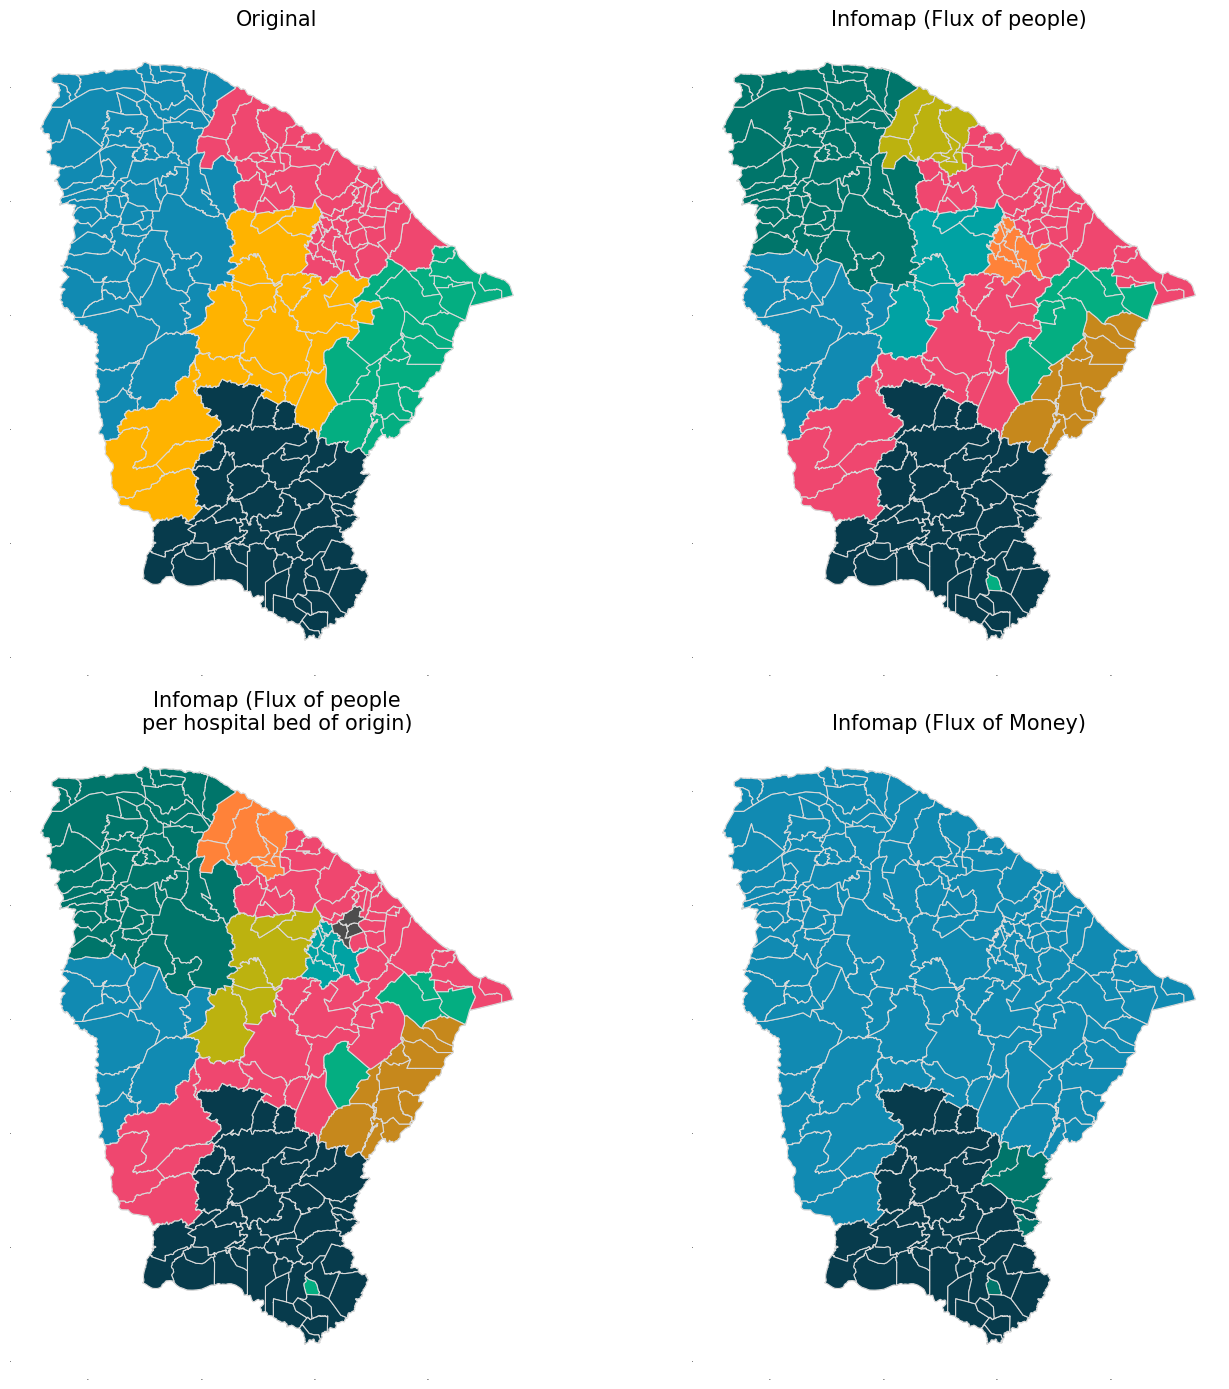

In [88]:
# -- new geometry ceará
fig_new, AX = plt.subplots(2, 2, figsize=(15,14))

geodata_df.set_geometry('geometry_municip').plot(ax=AX[0,0], color="#ffffff", edgecolor="#d9d9d9", linewidth=0.8)
geodata_df.set_geometry('geometry_municip').plot(ax=AX[0,1], color="#ffffff", edgecolor="#d9d9d9", linewidth=0.8)
geodata_df.set_geometry('geometry_municip').plot(ax=AX[1,0], color="#ffffff", edgecolor="#d9d9d9", linewidth=0.8)
geodata_df.set_geometry('geometry_municip').plot(ax=AX[1,1], color="#ffffff", edgecolor="#d9d9d9", linewidth=0.8)

geodata_df.set_geometry('geometry_municip').plot(ax=AX[0,0], color=geodata_df["MACRO_COLOR"], edgecolor="#d9d9d9", linewidth=0.8)
geodata_df.set_geometry('geometry_municip').plot(ax=AX[0,1], color=geodata_df["INFOMAP_COUNT_COLOR"], edgecolor="#d9d9d9", linewidth=0.8)
geodata_df.set_geometry('geometry_municip').plot(ax=AX[1,0], color=geodata_df["INFOMAP_HOSPBED_COLOR"], edgecolor="#d9d9d9", linewidth=0.8)
geodata_df.set_geometry('geometry_municip').plot(ax=AX[1,1], color=geodata_df["INFOMAP_COST_COLOR"], edgecolor="#d9d9d9", linewidth=0.8)

for i in ['left', 'right', 'top', 'bottom']:
    for axis in [AX[0,0], AX[0,1], AX[1,0], AX[1,1]]:
        axis.spines[i].set_linewidth(0)
        axis.tick_params(which='both', length=0, labelsize=0)

#fig_new.suptitle("Application of Infomap Algorithm")
AX[0,0].set_title("Original", fontsize=15)
AX[0,1].set_title("Infomap (Flux of people)", fontsize=15)
AX[1,0].set_title("Infomap (Flux of people\nper hospital bed of origin)", fontsize=15)
AX[1,1].set_title("Infomap (Flux of Money)", fontsize=15)


#ax_new.tick_params(which='both', length=0, labelsize=0)

fig_new.tight_layout()
#fig_new.savefig(os.path.join(gml_output, "FIGURAS", fname_infomap.split(".")[0]+"_INFOMAP.png"), dpi=300, bbox_inches='tight')

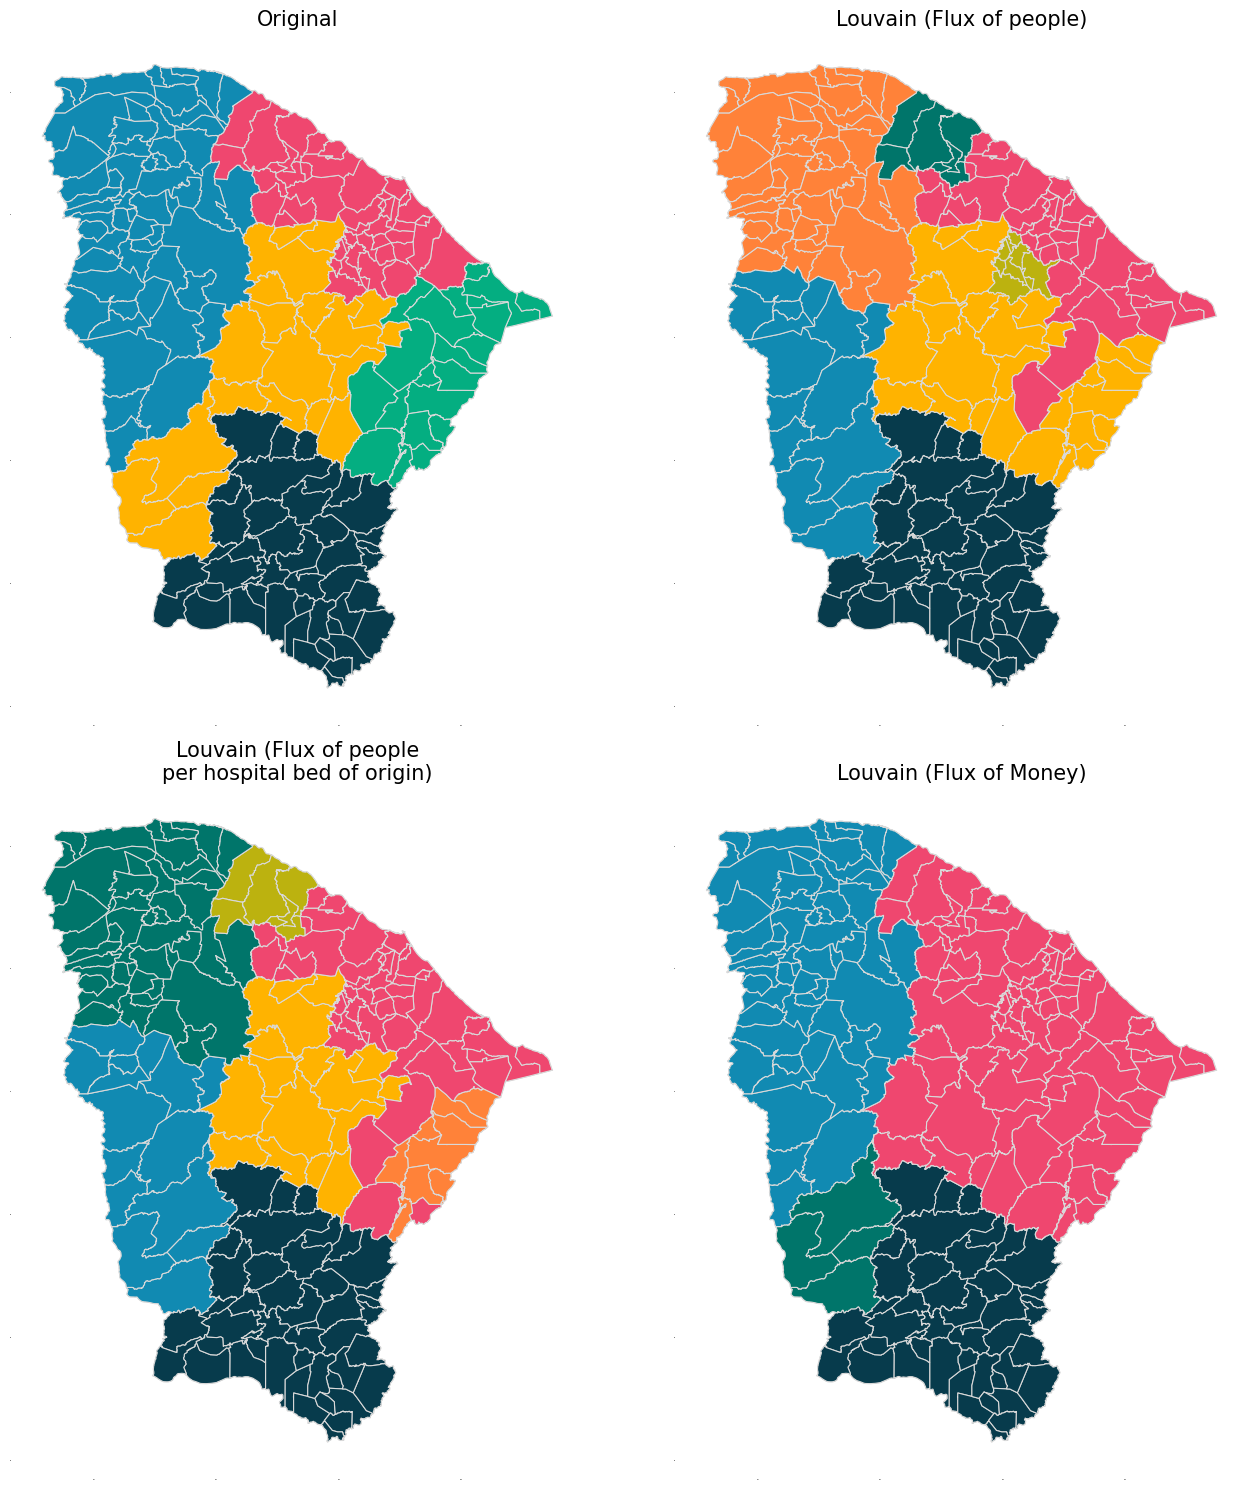

In [90]:
# -- new geometry ceará
fig_new, AX = plt.subplots(2, 2, figsize=(14,15))

geodata_df.set_geometry('geometry_municip').plot(ax=AX[0,0], color="#ffffff", edgecolor="#d9d9d9", linewidth=0.8)
geodata_df.set_geometry('geometry_municip').plot(ax=AX[0,1], color="#ffffff", edgecolor="#d9d9d9", linewidth=0.8)
geodata_df.set_geometry('geometry_municip').plot(ax=AX[1,0], color="#ffffff", edgecolor="#d9d9d9", linewidth=0.8)
geodata_df.set_geometry('geometry_municip').plot(ax=AX[1,1], color="#ffffff", edgecolor="#d9d9d9", linewidth=0.8)

geodata_df.set_geometry('geometry_municip').plot(ax=AX[0,0], color=geodata_df["MACRO_COLOR"], edgecolor="#d9d9d9", linewidth=0.8)
geodata_df.set_geometry('geometry_municip').plot(ax=AX[0,1], color=geodata_df["LOUVAIN_COUNT_COLOR"], edgecolor="#d9d9d9", linewidth=0.8)
geodata_df.set_geometry('geometry_municip').plot(ax=AX[1,0], color=geodata_df["LOUVAIN_HOSPBED_COLOR"], edgecolor="#d9d9d9", linewidth=0.8)
geodata_df.set_geometry('geometry_municip').plot(ax=AX[1,1], color=geodata_df["LOUVAIN_COST_COLOR"], edgecolor="#d9d9d9", linewidth=0.8)

for i in ['left', 'right', 'top', 'bottom']:
    for axis in [AX[0,0], AX[0,1], AX[1,0], AX[1,1]]:
        axis.spines[i].set_linewidth(0)
        axis.tick_params(which='both', length=0, labelsize=0)

#fig_new.suptitle("Application of Infomap Algorithm")
AX[0,0].set_title("Original", fontsize=15)
AX[0,1].set_title("Louvain (Flux of people)", fontsize=15)
AX[1,0].set_title("Louvain (Flux of people\nper hospital bed of origin)", fontsize=15)
AX[1,1].set_title("Louvain (Flux of Money)", fontsize=15)


#ax_new.tick_params(which='both', length=0, labelsize=0)

fig_new.tight_layout()
#fig_new.savefig(os.path.join(gml_output, "FIGURAS", fname_infomap.split(".")[0]+"_INFOMAP.png"), dpi=300, bbox_inches='tight')

In [91]:
geodata_df["LOUVAIN_COST_COLOR"].value_counts()

LOUVAIN_COST_COLOR
#ef476f    80
#118ab2    55
#073b4c    45
#00756a     4
Name: count, dtype: int64

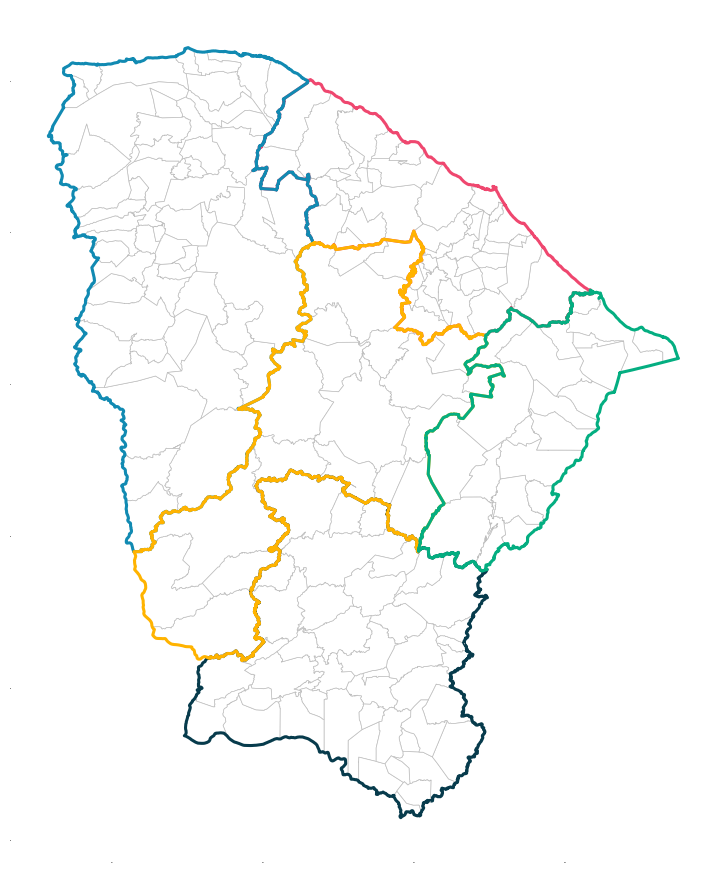

In [108]:
cmap_macro = {1: "#ef476f", 2: "#ffb300", 3: "#04ae81", 4: "#118ab2", 5: "#073b4c"}
geodata_df['MACRO_COLOR'] = geodata_df["MACRO_ID"].map(cmap_macro)
#macro_df['MACRO_COLOR'] = macro_df["ID"].map(cmap_macro)
#mun_df1.head()

# -- geometry ceará
fig1, ax1 = plt.subplots(1, figsize=(12,11))

geodata_df.set_geometry('geometry_municip').plot(ax=ax1, color="#ffffff", edgecolor="#bfbfbf", linewidth=0.5)
geodata_df.set_geometry('geometry_macro').drop_duplicates("MACRO_ID").plot(ax=ax1, color="none", edgecolor=geodata_df.drop_duplicates("MACRO_ID")["MACRO_COLOR"], linewidth=2.2)

#mun_df1.plot(ax=ax1, color="#ffffff", edgecolor="#bfbfbf", linewidth=0.5)
#macro_df.plot(ax=ax1, color="none", edgecolor=geodata_df["MACRO_COLOR"], linewidth=2.2)

for i in ['left', 'right', 'top', 'bottom']:
    ax1.spines[i].set_linewidth(0)

ax1.tick_params(which='both', length=0, labelsize=0)

In [167]:
geodata_df[geodata_df["NM_MUNICIP"]=="FORTALEZA"]

,GEOCOD7,NM_MUNICIP,GEOCOD6,MACRO_ID,CRES_ID,geometry_municip,MACRO_NOME,geometry_macro,geometry_cres,centroid_municip,municip_lon,municip_lat,2018-2022(MEAN),INFOMAP_COUNT_MODULE,INFOMAP_COST_MODULE,INFLOW_PEOPLE,INFLOW_COST,MACRO_COLOR
58,2304400,FORTALEZA,230440,1,1,"POLYGON ((-38.59236 -3.70089, -38.59108 -3.699...",Superintendência Regional de Saúde Fortaleza,"MULTIPOLYGON (((-39.69667 -2.99902, -39.69216 ...","POLYGON ((-4291290.757 -433529.615, -4290910.0...",POINT (-38.52770 -3.78566),-38.527701,-3.785656,2627931.0,1,1,378362,869550234.9,#ef476f


In [95]:
for u in graph.nodes():
    in_edges = [ e for e in graph.in_edges(u) ]
    graph.nodes[u]['incoming_people'] = 0
    graph.nodes[u]['incoming_cost'] = 0
    for e in in_edges:
        graph.nodes[u]['incoming_people'] += graph.edges[e]['admission_count']
        graph.nodes[u]['incoming_cost'] += graph.edges[e]['total_cost']

In [94]:
[n for n in graph.in_edges('4')][0]

('3', '4')

In [111]:
def power_law_f(x, prefactor, power):
    return prefactor*(x**power)

exponent: 2.4672204367017696, prefactor: -9.004516053121526


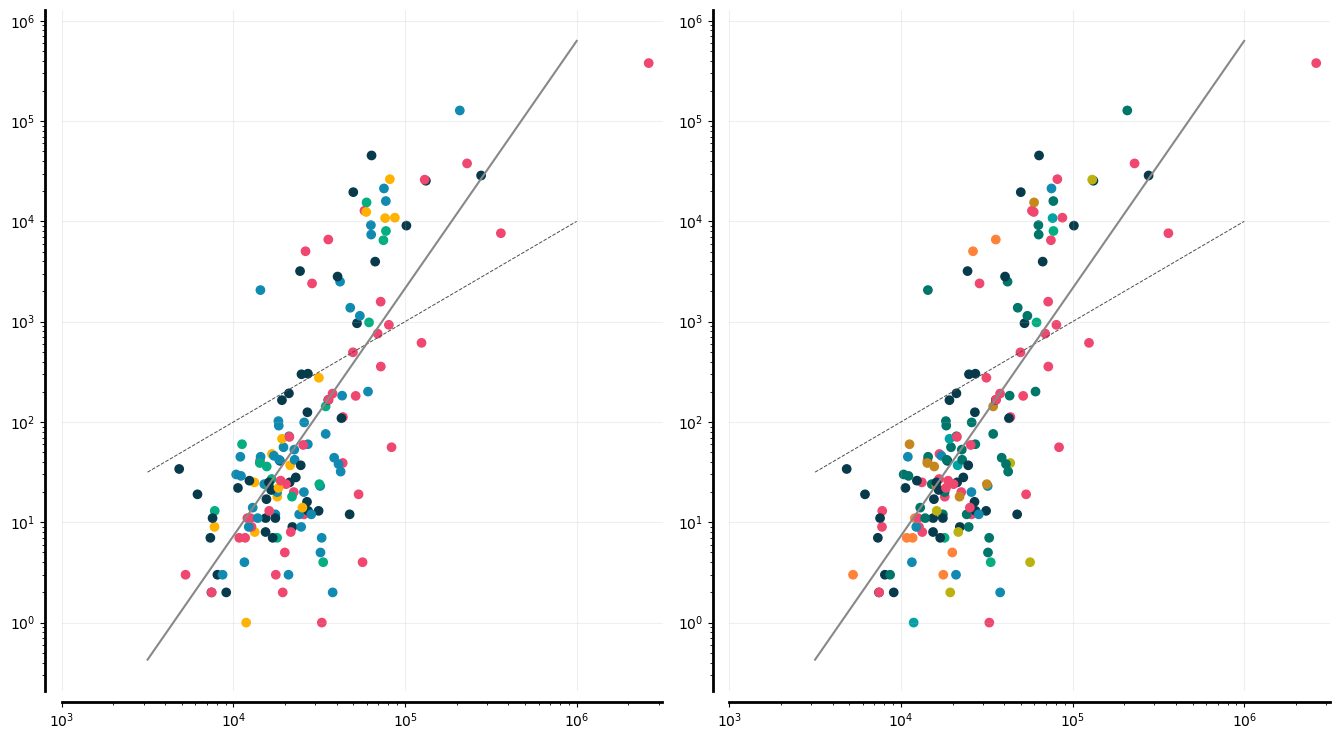

In [229]:
# -- fit
xdata = geodata_df[geodata_df["inflow_people"]!=0]["2018-2022(MEAN)"]
ydata = geodata_df[geodata_df["inflow_people"]!=0]["inflow_people"]

res_ = linregress(np.log10(xdata.values), np.log10(ydata.values))
print(f"exponent: {res_.slope}, prefactor: {res_.intercept}")


figs, (axs11, axs12) = plt.subplots(1,2, figsize=(13.5,7.5))

axs11.grid(alpha=0.2, zorder=0)
axs12.grid(alpha=0.2, zorder=0)
# -- spines
for i in ['left', 'right', 'bottom', 'top']:
    axs11.spines[i].set_linewidth(2)
    axs12.spines[i].set_linewidth(2)

axs11.spines['top'].set_linewidth(0)
axs11.spines['right'].set_linewidth(0)
axs11.spines['bottom'].set_position(('outward', 8))
axs11.spines['left'].set_position(('outward', 12))
axs12.spines['top'].set_linewidth(0)
axs12.spines['right'].set_linewidth(0)
axs12.spines['bottom'].set_position(('outward', 8))
axs12.spines['left'].set_position(('outward', 12))

# -- slope 1
x = np.logspace(3.5, 6, 10, base=10)
y = power_law_f(x, 10**-2, 1)
axs11.plot(x, y, ls="--", color="#4d4d4d", lw=0.7)
axs12.plot(x, y, ls="--", color="#4d4d4d", lw=0.7)
# -- fitted slope
y_fit = power_law_f(x, 10**res_.intercept, res_.slope)
axs11.plot(x, y_fit, ls="-", color="#888888", lw=1.5)
axs12.plot(x, y_fit, ls="-", color="#888888", lw=1.5)

axs11.set_xlim([10**3, 10**6.5])
axs12.set_xlim([10**3, 10**6.5])

# points
axs11.scatter(geodata_df["2018-2022(MEAN)"], geodata_df["inflow_people"], color=geodata_df["MACRO_COLOR"])
axs12.scatter(geodata_df["2018-2022(MEAN)"], geodata_df["inflow_people"], color=geodata_df["INFOMAP_COUNT_COLOR"])
axs11.set_xscale('log')
axs11.set_yscale('log')
axs12.set_xscale('log')
axs12.set_yscale('log')

figs.tight_layout()

exponent: 2.716824101794341, prefactor: -7.386871179063773


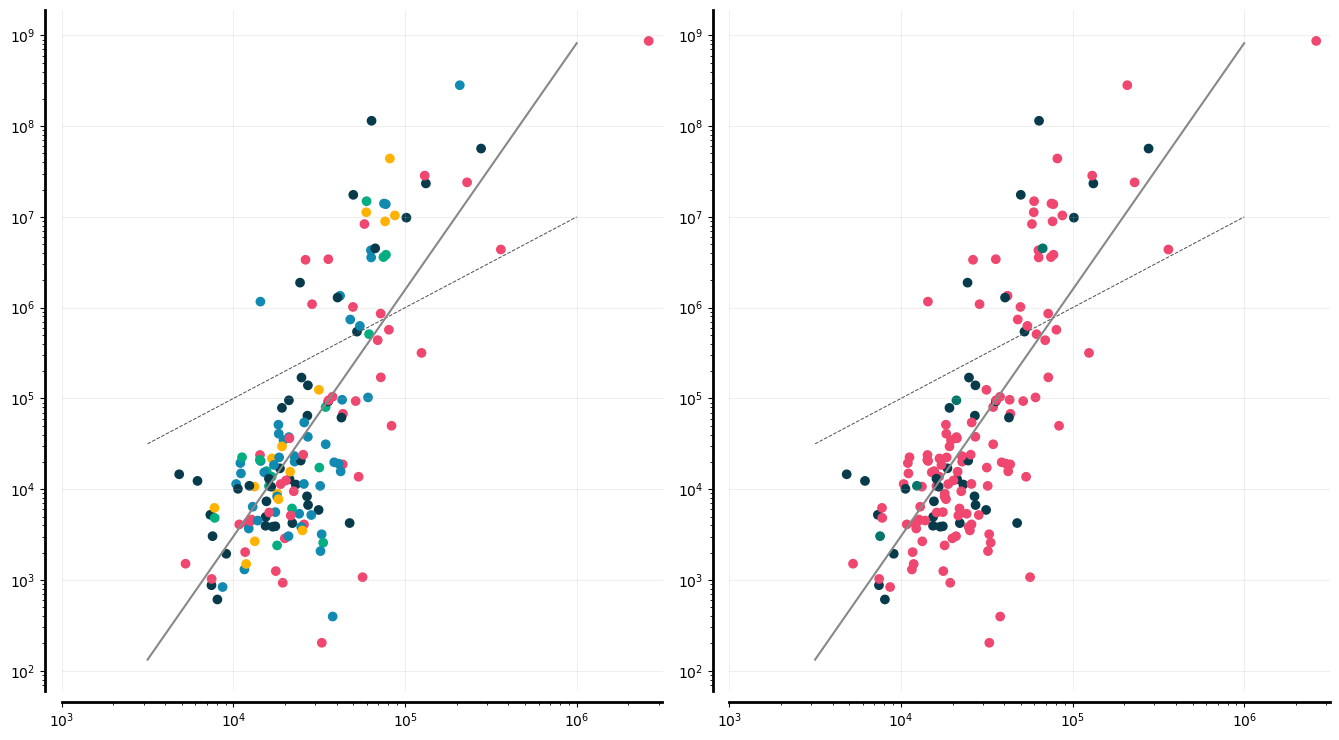

In [230]:
# -- fit
xdata = geodata_df[geodata_df["inflow_cost"]!=0]["2018-2022(MEAN)"]
ydata = geodata_df[geodata_df["inflow_cost"]!=0]["inflow_cost"]

res_ = linregress(np.log10(xdata.values), np.log10(ydata.values))
print(f"exponent: {res_.slope}, prefactor: {res_.intercept}")

figs, (axs11, axs12) = plt.subplots(1,2, figsize=(13.5,7.5))

axs11.grid(alpha=0.2, zorder=0)
axs12.grid(alpha=0.2, zorder=0)
# -- spines
for i in ['left', 'right', 'bottom', 'top']:
    axs11.spines[i].set_linewidth(2)
    axs12.spines[i].set_linewidth(2)

axs11.spines['top'].set_linewidth(0)
axs11.spines['right'].set_linewidth(0)
axs11.spines['bottom'].set_position(('outward', 8))
axs11.spines['left'].set_position(('outward', 12))
axs12.spines['top'].set_linewidth(0)
axs12.spines['right'].set_linewidth(0)
axs12.spines['bottom'].set_position(('outward', 8))
axs12.spines['left'].set_position(('outward', 12))

# -- slope 1
x = np.logspace(3.5, 6, 10, base=10)
y = power_law_f(x, 10**1, 1)
axs11.plot(x, y, ls="--", color="#4d4d4d", lw=0.7)
axs12.plot(x, y, ls="--", color="#4d4d4d", lw=0.7)
# -- fitted slope
y_fit = power_law_f(x, 10**res_.intercept, res_.slope)
axs11.plot(x, y_fit, ls="-", color="#888888", lw=1.5)
axs12.plot(x, y_fit, ls="-", color="#888888", lw=1.5)

axs11.set_xlim([10**3, 10**6.5])
axs12.set_xlim([10**3, 10**6.5])

# points
axs11.scatter(geodata_df["2018-2022(MEAN)"], geodata_df["inflow_cost"], color=geodata_df["MACRO_COLOR"])
axs12.scatter(geodata_df["2018-2022(MEAN)"], geodata_df["inflow_cost"], color=geodata_df["INFOMAP_COST_COLOR"])
axs11.set_xscale('log')
axs11.set_yscale('log')
axs12.set_xscale('log')
axs12.set_yscale('log')

figs.tight_layout()

In [128]:
xdata = geodata_df[geodata_df["inflow_people"]!=0]["2018-2022(MEAN)"]
ydata = geodata_df[geodata_df["inflow_people"]!=0]["inflow_people"]

res_ = linregress(np.log10(xdata.values), np.log10(ydata.values))